#**ECE 4554/ ECE 5554 / Computer Vision**
This file contains Problem 5, which is the coding portion of Homework 3. Your job is to implement/modify the sections within this notebook that are marked with "TO DO".

##**TO DO**: Enter your Virginia Tech Username (PID) here: 906465121

##**Honor Code reminder**

This is not a "team project". Please review the Honor Code statement in the syllabus.  

##**Submission guidelines** for the coding problems (Google Colab)

1. Please verify that you have entered your Virginia Tech Username in all of the appropriate places.
2. After clicking Runtime->Run all, verify that all of your solutions are visible in this notebook.
3. Click File->Save near the top of the page to save the latest version of your notebook at Google Drive.
4. Verify that the last 2 cells have executed, creating a PDF version of this notebook at Google Drive. (Note: if you face difficulty with this step, please refer to https://pypi.org/project/notebook-as-pdf/)
5. Look at the PDF file and check that all of your solutions are displayed correctly there.
6. Download your notebook file and the PDF version to your laptop.
7. On your laptop, create a ZIP version of this notebook file. (Please don't include the separate data files.) Use file name Homework3_Code_USERNAME.zip, with your own Username.
6. For your PDF version, use file name Homework3_Notebook_USERNAME.pdf, with your own Username.
7. **Submit these 2 files and your PDF file for Problems 1-4 SEPARATELY to Canvas.** Do not zip them all together.

##**Overview**

This problem consists of the following 4 parts. By completing these parts, you will develop code that will automatically create a composite image from several overlapping images. Each part has equal weight in grading.

a) 2D homography

b) Image warping

c) RANSAC using SIFT keypoints

d) Image stitching

# Environment setup

In [1]:
# Mount your Google Drive to this notebook
# The purpose is to allow your code to access to your files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# Change the directory to your own working directory
# Any files under your working directory are available to your code
# TO DO: enter the name of your directory
import os
os.chdir('/content/drive/MyDrive/Comp Vision')


In [9]:
# The following is needed to allow the use of SIFT 
# (need OpenCV version 4.5 or later)
# For a new installation, you may see a message:
#  "You must restart the runtime in order to use newly installed versions." 
#  One way to do this is to click "Runtime" -> "Restart Runtime"
# If you see an error message, you may need to run this step again, after running the "Import" block that follows
!pip install opencv-python==4.5.3.*

In [10]:
# Import library modules
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
# PIL is the Python Imaging Library
from PIL import Image  
# The following is a substitute for cv2.imshow, which Colab does not allow
from google.colab.patches import cv2_imshow

print('Python version:', sys.version)
print('OpenCV version:', cv2.__version__)
print('NumPy version: ', np.__version__)


Python version: 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
OpenCV version: 4.5.3
NumPy version:  1.19.5


#Getting started

Several image files were provided to you (Newman*.png, mandrill.tif, Rubiks_cube.jpg). Upload all of them to your working directory.

The following functions are helpful for loading images into floating-point format, and for displaying images that are in that format.  Let's use those functions to visualize 3 separate images that we want to stitch together. Notice that you can adjust the size of the figure that is displayed.


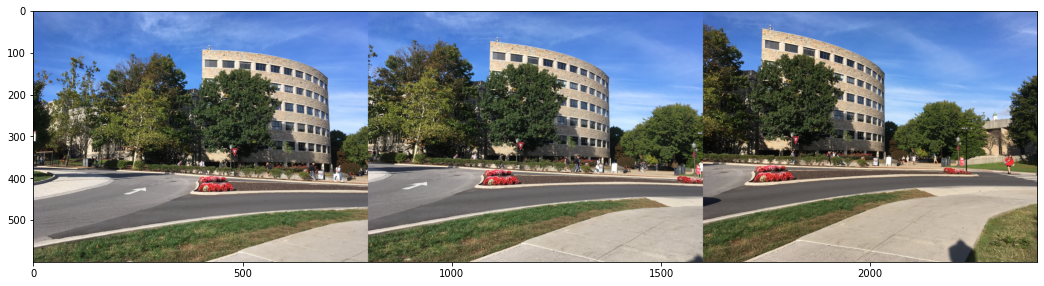

In [11]:
def load_image(filename):
  img = np.asarray(Image.open(filename))
  img = img.astype("float32")/255.0
  return img

def show_image(img):
  fig = plt.figure()
  fig.set_size_inches(18, 10) # You can adjust the size of the displayed figure
  plt.imshow(img)

left_img = load_image("Newman1.png")
center_img = load_image("Newman2.png")
right_img = load_image("Newman3.png")
show_image(np.concatenate([left_img, center_img, right_img], axis=1))

Next, verify that you can use OpenCV tools to detect SIFT-based keypoints. These library functions allow for many options. For example, if you change the `nfeatures` parameter for `SIFT_create`, you'll see different numbers of detected keypoints. You may want to experiment with these parameters later.

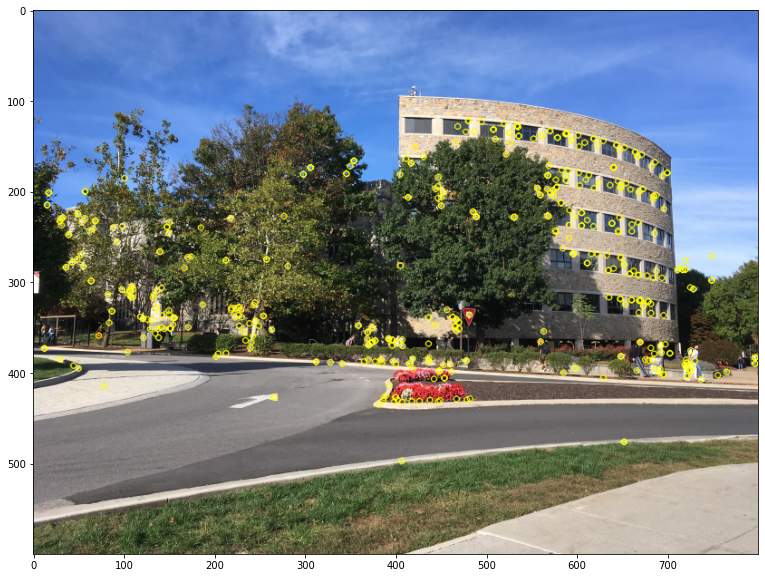

In [12]:
def testSIFT(img1):
  sift = cv2.SIFT_create(nfeatures=500)
  kp = sift.detect(img1, None)
  img1=cv2.drawKeypoints(img1, kp, None, color=(0, 255, 255))
  
  fig = plt.figure()
  fig.set_size_inches(18,10) # You can adjust the size of the displayed figure
  plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))


img = cv2.imread("Newman1.png", cv2.IMREAD_COLOR)
testSIFT(img)

#Part (a):  2D homography

Implement the 2 functions that are shown in the next code block. (OpenCV has a findHomography() function, and other related functions, but for this assignment you must write your own version.)

1.   **compute_homography(src, dst)** receives two matrices, each of size Nx2. Each matrix contains N two-dimensional points. For each value of i, src[i] and dst[i] are corresponding points from two different images. The function should return the homography matrix H of size 3x3 that maps every point from the source (src) to the destination (dst).   Guidance: You may assume that N is at least 4. You can set up the problem in a matrix-based, least-squares format. (A somewhat similar problem is in the lecture slides on page 40 of packet 5.) Helpful functions are `np.linalg.eig()` and `np.linalg.eigh()` for computing eigenvalues and eigenvectors. The latter function will prevent warnings due to small imaginary values if you are working with matrices that are real and symmetric. 
2.   **apply_homography(src, H)** receives points in matrix src (an Nx2 matrix), and a homography transformation H (a 3x3 matrix). This function should use the homography matrix to transform each point in src to a new destination point. Store the resulting points in matrix dst, which is the same size as src. The function should return dst. Guidance: remember to use homogeneous coordinates when implementing this transformation.



In [13]:
def compute_homography(src, dst):
  '''Computes the homography from src to dst.
   Input:
    src: source points, shape (N, 2), where N >= 4
    dst: destination points, shape (N, 2)
   Output:
    H: homography from source points to destination points, shape (3, 3)

   TO DO: Implement the compute_homography function
  '''
  # The following line is just a place-holder
  # H = np.matrix('1, 0, 0; 0, 1, 0; 0, 0, 1')
  #fH = cv2.findHomography(src, dst)
  #print(fH)
  #print(src.shape)
  Q = np.empty([src.shape[0]*2,9])
  for i in range(src.shape[0]):
    row = np.array([-src[i,0],-src[i,1],-1,0,0,0,src[i,0]*dst[i,0],src[i,1]*dst[i,0],dst[i,0]])
    Q[i*2,0:9] = row
    row = np.array([0,0,0,-src[i,0],-src[i,1],-1,src[i,0]*dst[i,1],src[i,1]*dst[i,1],dst[i,1]])
    Q[(i*2)+1,0:9] = row 
 
  #print (Q)
  u, s, v = np.linalg.svd(Q)

  H = np.reshape(v[8],(3,3))
  H = (1/H.item(8)) * H
  return H

#print(H)
def apply_homography(src, H):
  '''Applies a homography H to the source points.
   Input:
      src: source points, shape (N, 2)
      H: homography from source points to destination points, shape (3, 3)
   Output:
     dst: destination points, shape (N, 2)

   TO DO: Implement the apply_homography function
  '''
  dst = np.zeros([src.shape[0], 2])

  for i in range(src.shape[0]):
    sour = np.reshape([src[i,0],src[i,1],1],(3,1))
    mul = np.dot(H,sour)
    mul = (1/mul.item(2))*mul
    dst[i,0]= mul[0,0]
    dst[i,1]=mul[1,0]  

  return dst

You do not need to change the following function. It will test your homography code, and should help you in debugging. Corresponding points are placed in src_pts and dst_pts. If your homography code is correct, it should map the points given in test_pts to locations that are close to the points given in match_pts_correct. If you have correctly implemented compute_homography() and apply_homography(), then the printed difference values should be close to 0. (A small difference, such as 0.001, should be acceptable.)

In [14]:
def test_homography():
  src_pts = np.matrix('0, 0; 1, 0; 1, 1; 0, 1')
  dst_pts = np.matrix('5, 4; 7, 4; 7, 5; 6, 6')
  H = compute_homography(src_pts, dst_pts)
  test_pts = np.matrix('0,  0; 1, 0; 1, 1; 0, 1')
  match_pts = apply_homography(test_pts, H)
  match_pts_correct = np.matrix('5, 4; 7, 4; 7, 5; 6, 6')
  print('Your 1st solution differs from our solution by: %f'
    % np.square(match_pts - match_pts_correct).sum())
  
  src_pts = np.matrix('0, 0; 1, 0; 1, 1; 0, 1; 2, 3')
  dst_pts = np.matrix('5, 4; 7, 4; 7, 5; 6, 6; 7.25, 5.5')
  H = compute_homography(src_pts, dst_pts)
  test_pts = np.matrix('0,  0; 1, 0; 1, 1; 0, 1')
  match_pts = apply_homography(test_pts, H)
  match_pts_correct = np.matrix('5, 4; 7, 4; 7, 5; 6, 6')
  print('Your 2nd solution differs from our solution by: %f'
    % np.square(match_pts - match_pts_correct).sum())
  
  src_pts = np.matrix('347, 313; 502, 341; 386, 571; 621, 508')
  dst_pts = np.matrix('274, 286; 436, 305; 305, 527; 615, 506')
  H = compute_homography(src_pts, dst_pts)
  test_pts = np.matrix('259, 505; 350, 371; 400, 675; 636, 104')
  match_pts = apply_homography(test_pts, H)
  match_pts_correct = np.matrix('195.13761083, 448.12645033;'
    '275.27269386, 336.54819916;'
    '317.37663747, 636.78403426;'
    '618.50438823, 28.78963905')
  print('Your 3rd solution differs from our solution by: %f'
    % np.square(match_pts - match_pts_correct).sum())
  
test_homography()

Your 1st solution differs from our solution by: 0.000000
Your 2nd solution differs from our solution by: 0.000000
Your 3rd solution differs from our solution by: 0.000000


#Part (b):  Image warping using a 2D homography

Implement the following function so that it performs image warping from a source image (src_img) to a newly created destination image (dst_img). Do not use any additional OpenCV functions. The homography H that is provided indicates a desired mapping from src_img to dst_img. To prevent gaps in the output image, however, it is suggested that your implementation should iterate over all pixels in dst_img. In that case, your code should use the *inverse* of H to find values in src_img as it iterates over dst_img.

In [15]:
def warp_img(src_img, H, dst_img_size):
  '''Warping of a source image using a homography.
   Input:
      src_img: source image with shape (m, n, 3)
      H: homography, with shape (3, 3), from source image to destination image
      dst_img_size: height and width of destination image; shape (2,)
   Output:
      dst_img: destination image; height and width specified by dst_img_size parameter

   TO DO: Implement the warp_img function.
  '''
  dst_img = np.zeros([dst_img_size[0], dst_img_size[1], 3])
  #print(dst_img)

  h_inv = np.linalg.inv(H)
  #h_inv = h_inv/(h_inv[2,2])
  #print(h_inv)

  for i in range(dst_img_size[0]-1):
    for j in range(dst_img_size[1]-1):
      dest = np.empty([3,1])
      dest= [[i],[j],[1]]


      #source_point = np.round(h_inv.dot(dest)).astype(int)
      source_point = np.matmul(h_inv,dest)
      source_point = source_point/source_point[2,0]
      source_point = np.round(source_point).astype(int)
      if(source_point[0]>=0 and source_point[0]<=src_img.shape[1] and source_point[1]>=0 and source_point[1]<=src_img.shape[0] ):
        try:
          dst_img[j,i] =src_img[source_point[1],source_point[0]]
        except:
          pass 
      #print(source_point)

  
  return dst_img

Use the functions below to help debug your implementation. You do not need to modify these functions. If your code is correct, the output here should show a  mandrill image that has been warped to overlay the blue side of a Rubik's cube.

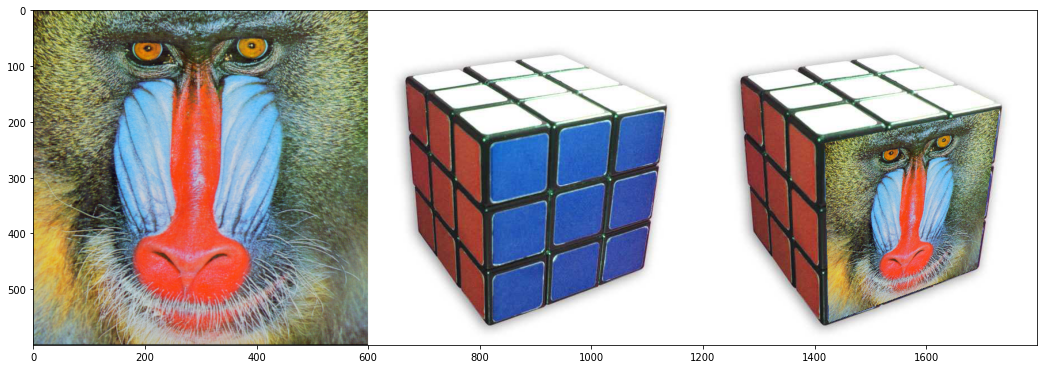

In [16]:
def binary_mask(img):
  '''Create a binary mask of the image content.
   Input:
    img: source image, shape (m, n, 3)
   Output:
    mask: image of shape (m, n) and type 'int'. For pixel [i, j] of mask, 
      if pixel [i, j] in img is nonzero in any channel, assign 1 to mask[i, j]. 
      Else, assign 0 to mask[i, j].
  '''
  mask = (img[:, :, 0] > 0) | (img[:, :, 1] > 0) | (img[:, :, 2] > 0)
  mask = mask.astype("int")
  return mask

def test_warp():
  src_img = load_image('mandrill.tif')
  canvas_img = load_image('Rubiks_cube.jpg')

  # The following are corners of the mandrill image
  src_pts = np.matrix('0, 0; 0, 511; 511, 511; 511, 0')
  # The following are corners of the blue face of the Rubik's cube
  canvas_pts = np.matrix('218, 238; 225, 560; 490, 463; 530, 178')

  # The following was used during debugging
  # print(canvas_pts)
  # test_x=218
  # test_y=238
  # cv2.circle(canvas_img, (218, 238), 4, (255, 0, 0), thickness=10)

  H = compute_homography(src_pts, canvas_pts)
  dst_img = warp_img(src_img, H, [canvas_img.shape[0], canvas_img.shape[1]])
  dst_mask = 1 - binary_mask(dst_img)
  dst_mask = np.stack((dst_mask,) * 3, -1)
  out_img = np.multiply(canvas_img, dst_mask) + dst_img
  
  dsize = (600, 600) # width and height of canvas_im
  src_smaller = cv2.resize(src_img, dsize, interpolation=cv2.INTER_AREA)
  
  warped_img = np.concatenate((src_smaller, canvas_img, out_img), axis=1)
  show_image(np.clip(warped_img, 0, 1))

test_warp()

#Part (c) RANSAC using SIFT keypoints

You have already confirmed that you can detect SIFT-based keypoints. Next, verify that you can use a matching technique from OpenCV that tries to detect corresponding keypoints between 2 images. The code should display the correspondences and draw lines between them.

By the way, cv2.BFmatcher() is OpenCV's "brute force" matcher. More description is given in 
https://github.com/abidrahmank/OpenCV2-Python-Tutorials/blob/master/source/py_tutorials/py_feature2d/py_matcher/py_matcher.rst

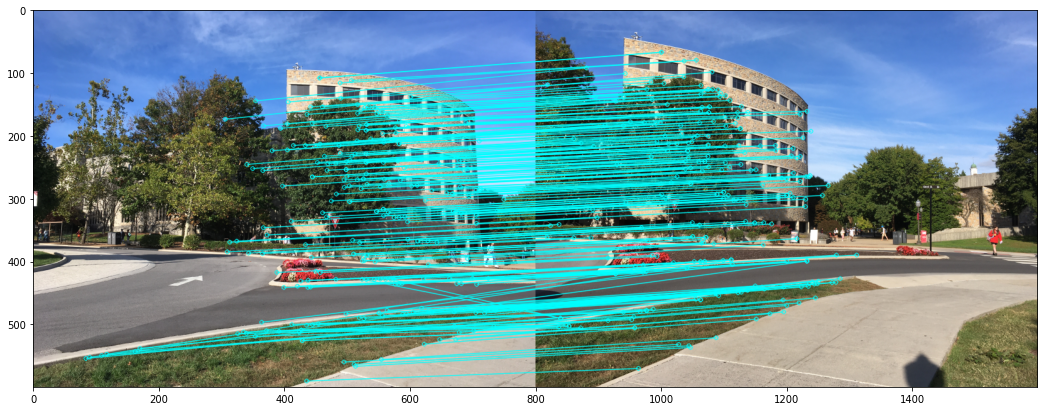

In [17]:
def genSIFTMatchPairs(img1, img2):
  sift = cv2.SIFT_create()
  #kp = sift.detect(img1, None)
  #kp = cv2.SIFT(edgeThreshold=10)
  kp1, des1 = sift.detectAndCompute(img1, None)
  kp2, des2 = sift.detectAndCompute(img2, None)
  bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
  matches = bf.match(des1, des2)
  matches = sorted(matches, key = lambda x:x.distance)

  pts1 = np.zeros((250, 2))
  pts2 = np.zeros((250, 2))
  for i in range(250):
    pts1[i,:] = kp1[matches[i].queryIdx].pt
    pts2[i,:] = kp2[matches[i].trainIdx].pt

  return pts1, pts2, matches[:250], kp1, kp2

def test_matches():
  img1 = cv2.imread('Newman1.png')
  img2 = cv2.imread('Newman3.png')
  pts1, pts2, matches1to2, kp1, kp2 = genSIFTMatchPairs(img1, img2)

  # In the following, parameter flags=2 will remove unmatched points from the display
  matching_result = cv2.drawMatches(img1, kp1, img2, kp2, matches1to2, None, flags=2,
    matchColor = (255, 255, 0), singlePointColor=(0, 0, 255))
  
  fig = plt.figure()
  fig.set_size_inches(18,10) # You can adjust the size of the displayed figure
  plt.imshow(cv2.cvtColor(matching_result, cv2.COLOR_BGR2RGB))


test_matches()

Notice that some of the matches from the previous step are not correct. It is possible that those false matches could act as outliers in your homography estimation. In that case we would expect a poor result in any composite image that we create. 

As discussed during lectures, the RANSAC algorithm is a popular way to deal with outliers during model fitting. Here you must implement your own function that uses the RANSAC approach to compute a homography H. 

In [18]:
def RANSAC(Xs, Xd, max_iter, eps):
  '''Find correspondences between two sets of points using the RANSAC algorithm.
   Input:
    Xs: the first set of points (source), shape [n, 2]
    Xd: the second set of points (destination) matched to the first set, shape [n, 2] 
    max_iter: max number of iterations that RANSAC should perform
    eps: tolerance of RANSAC
   Output:
    inliers_id: the indices of matched pairs when using the homography given by RANSAC
    H: the computed homography, shape [3, 3]

   TO DO: Implement the RANSAC function.
  '''
  H = np.zeros([3,3])
  inliers_id = []
  max_inlines = 0
  #print(Xs.shape)
  this_sample = np.random.randint(0,Xs.shape[0],size=4)
  #print(this_sample)

  for trial in range(max_iter):
    
    
    if(trial == 0):
      this_sample = np.random.randint(0,Xs.shape[0],size=4)
    else:
      this_sample = np.random.choice(inliers_id[0],size=4)
    #print(this_sample)

    pt_s = np.array([Xs[this_sample[0]],Xs[this_sample[1]],Xs[this_sample[2]],Xs[this_sample[3]]])
    pt_d = np.array([Xd[this_sample[0]],Xd[this_sample[1]],Xd[this_sample[2]],Xd[this_sample[3]]])

    H = compute_homography(pt_s,pt_d)
    Y =apply_homography(Xs,H)

    dist = np.linalg.norm(Y-Xd,axis=-1)
    inliers_id = np.where(dist <= eps)

    if len(inliers_id[0]) > max_inlines:
      max_inlines = len(inliers_id[0])
      inliers = inliers_id[0]

  H = compute_homography(Xs[inliers], Xd[inliers])



  return inliers, H


Now we can look at the matches between keypoints after using your RANSAC implementation. You do not need to modify the code in the next block. If you implemented RANSAC correctly, hopefully all of the incorrect matches have been discarded in the following output.

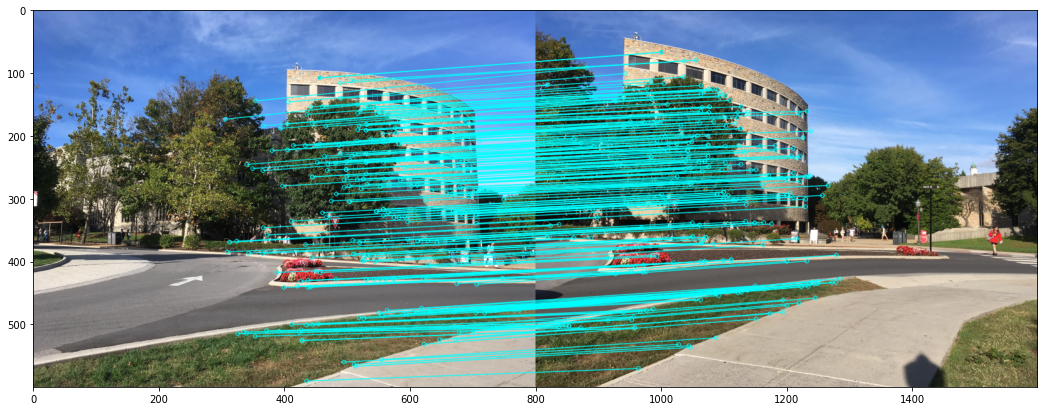

In [19]:
def test_ransac():
  img1 = cv2.imread('Newman1.png')
  img2 = cv2.imread('Newman3.png')
  pts1, pts2, matches1to2, kp1, kp2 = genSIFTMatchPairs(img1, img2)
  
  inliers_idx, H = RANSAC(pts1, pts2, 500, 50)
  new_matches = []
  for i in range(len(inliers_idx)):
    new_matches.append(matches1to2[inliers_idx[i]])

  matching_result = cv2.drawMatches(img1, kp1, img2, kp2, new_matches, None, flags=2, 
                                    matchColor = (255, 255, 0), singlePointColor=(0, 0, 255))

  fig = plt.figure()
  fig.set_size_inches(18, 10) # You can adjust the size of the displayed figure
  plt.imshow(cv2.cvtColor(matching_result, cv2.COLOR_BGR2RGB))

test_ransac()

#Part (d):  Image stitching.

We are now ready to create a panorama from the three images that were shown at the beginning. The stitch_img() function below receives a Python list of images, which the code should stitch together to form one large image.
You must use the functions that you have written to create the panorama. 

We do not expect the result to be perfect, partly because some lens distortion is always present and it will prevent the homography from aligning things perfectly. However, for full credit, try to write code that will stitch the images together with very little noticable seam.

In [20]:
def corp_img(img):
        img2=img.sum(axis=2)
        (row,col)=img2.shape
        rtop=0
        rdown=0
        ctop=0
        cdown=0
        for r in range(0,row):
                if img2.sum(axis=1)[r]>0:
                        rtop=r
                        break
 
        for r in range(row-1,0,-1):
                if img2.sum(axis=1)[r]>0:
                        rdown=r
                        break
 
        for c in range(0,col):
                if img2.sum(axis=0)[c]>0:
                        ctop=c
                        break
 
        for c in range(col-1,0,-1):
                if img2.sum(axis=0)[c]>0:
                        cdown=c
                        break
        #print(rtop)
        crop_img=img[rtop:rdown+1,ctop:cdown+1,0:3]
        return crop_img

def stitch_img(imgs):
  '''Stitch a list of images together.
   Input:
    imgs: a list of images.
   Output:
    stitched_img: a single stiched image.
  
   TO DO: implement the stitch_img function.
  '''
  # the following line is just a placeholder
  img_c = imgs[0]
  img_l = imgs[1]
  r, c = img_l.shape[:2]

  new_width = (c)//2
  new_height = (r)//2
  color = [0, 0, 0]
  #img_c = cv2.copyMakeBorder(img_c, new_height, new_height, new_width, new_width, cv2.BORDER_CONSTANT,value=color)
  img_c = np.zeros((img_c.shape[0]*3,img_c.shape[1]*3,3))
  img_c[imgs[0].shape[0]*1:imgs[0].shape[0]*2,imgs[0].shape[1]*1:imgs[0].shape[1]*2,:] = imgs[0]
  temp1 = img_c.astype('uint8')
  #print(temp1.shape)
  #print(imgs[0].shape)

  for i in range(1,len(imgs)):
    
    pts1, pts2, matches1to2, kp1, kp2 = genSIFTMatchPairs(imgs[i],temp1)
    inliers_idx, H = RANSAC(pts1, pts2, 500, 50)

    l,w = img_c.shape[:2]

    temp = warp_img(imgs[i], H, [l,w])

    temp1[:,:,:] = np.maximum(temp[:,:,:],temp1[:,:,:]).astype('uint8')
  final = corp_img(temp1)

  return final



Use the following code to test your implementation. This code just reads in the images, calls your stitch_img() function, and plots the results.


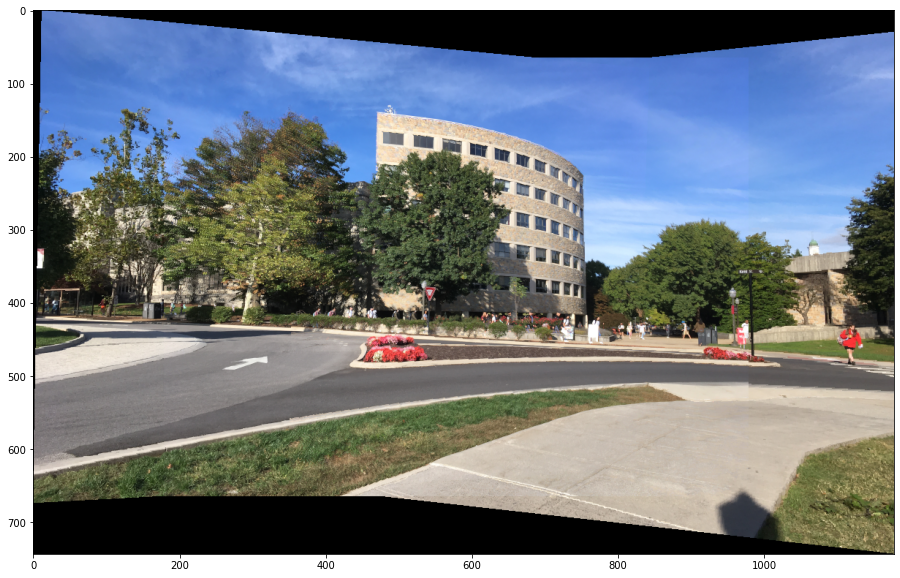

In [21]:
left_img = cv2.imread("Newman1.png")
center_img = cv2.imread("Newman2.png")
right_img = cv2.imread("Newman3.png")

final_img = stitch_img([center_img, left_img, right_img])

fig = plt.figure()
fig.set_size_inches(25,10) # You can adjust the size of the displayed figure
plt.imshow(cv2.cvtColor(final_img.astype("uint8"), cv2.COLOR_BGR2RGB))


Finally, use 3 or more photos of your own to create a panorama. It is suggested that you take new photos using your camera (e.g., with your phone or laptop). Remember to stand in place and try to rotate the camera about its point of projection. (If the camera position changes, then the transformation between 2 images is no longer a homography.)

**Please include these new photos as part of your HW3 submission.** We would like to select the best panoramas (as decided by the graders) to show during a lecture. (If you prefer that we do not show your photos to the class, that is fine. In that case, please tell us using a comment at the top of the following code block.) To reduce computation time, it is acceptable to resize your images down to a smaller size before processing them. You could consider using `cv2.resize()` for that purpose. For example, the provided Newman Library images were reduced to 800x600 from much larger dimensions.



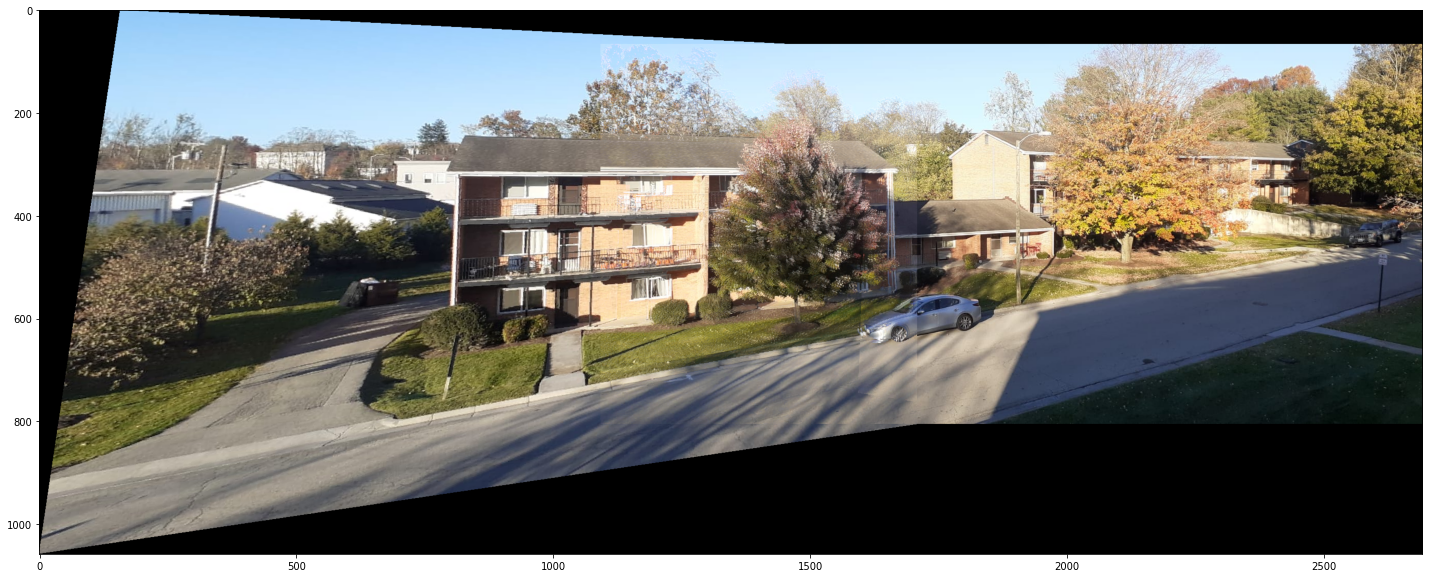

In [22]:
# TO DO: Load your own images here and create a panorama. 
l = cv2.imread("l.jpeg")
c = cv2.imread("c.jpeg")
r = cv2.imread("r1.jpeg")
dim = (800, 600)
cv2.resize(l,dim)
cv2.resize(c,dim)
cv2.resize(r,dim)
final_img = stitch_img([c, l, r])

fig = plt.figure()
fig.set_size_inches(25,10) # You can adjust the size of the displayed figure
plt.imshow(cv2.cvtColor(final_img.astype("uint8"), cv2.COLOR_BGR2RGB))

**Problem 5.** Near the end of your Jupyter notebook file for the previous problem, append new code blocks and text blocks in which you make comparisons between SIFT-based and ORB-based keypoints. Do not change your answers for Problem 4, but instead add new blocks at the end of the notebook file in which you write code that detects both types of keypoints. You may use images that have been provided to you, or you may upload images of your own. Add text block(s) in which you discuss the relative merits of these two types of keypoints. Try to find cases in which SIFT performs better than ORB, and vice versa. Clearly indicate those cases to the grader. You may discuss differences the accuracy of matches that are reported, differences in computation time, or other differences that you find to be interesting.





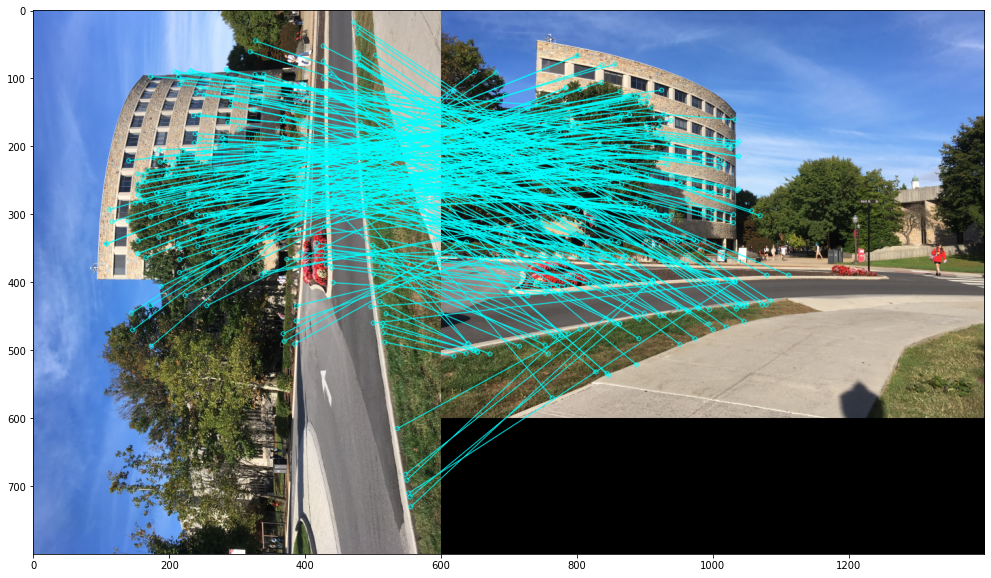

In [23]:
def genSIFTMatchPairs(img1, img2):
  sift = cv2.SIFT_create()
  #kp = sift.detect(img1, None)
  #kp = cv2.SIFT(edgeThreshold=10)
  kp1, des1 = sift.detectAndCompute(img1, None)
  kp2, des2 = sift.detectAndCompute(img2, None)
  bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
  matches = bf.match(des1, des2)
  matches = sorted(matches, key = lambda x:x.distance)

  pts1 = np.zeros((250, 2))
  pts2 = np.zeros((250, 2))
  for i in range(250):
    pts1[i,:] = kp1[matches[i].queryIdx].pt
    pts2[i,:] = kp2[matches[i].trainIdx].pt

  return pts1, pts2, matches[:250], kp1, kp2

def test_matches():
  img1 = cv2.imread('Newman1_rot.png')
  img2 = cv2.imread('Newman3.png')
  pts1, pts2, matches1to2, kp1, kp2 = genSIFTMatchPairs(img1, img2)

  # In the following, parameter flags=2 will remove unmatched points from the display
  matching_result = cv2.drawMatches(img1, kp1, img2, kp2, matches1to2, None, flags=2,
    matchColor = (255, 255, 0), singlePointColor=(0, 0, 255))
  
  fig = plt.figure()
  fig.set_size_inches(18,10) # You can adjust the size of the displayed figure
  plt.imshow(cv2.cvtColor(matching_result, cv2.COLOR_BGR2RGB))


test_matches()

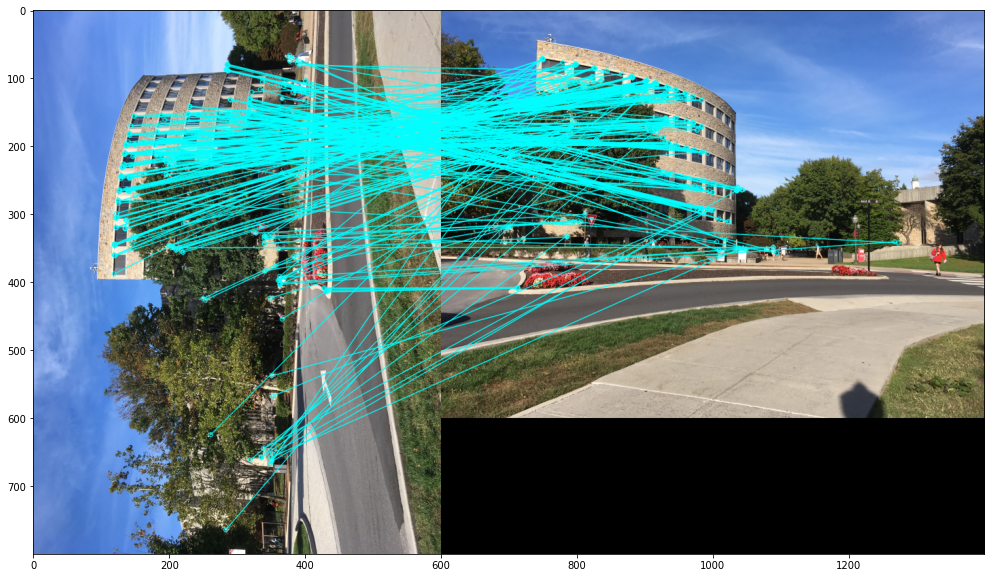

In [24]:
def genORBMatchPairs(img1, img2):
  orb = cv2.ORB_create()
  kp1, des1 = orb.detectAndCompute(img1, None)
  kp2, des2 = orb.detectAndCompute(img2, None)
  bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
  matches = bf.match(des1, des2)
  matches = sorted(matches, key = lambda x:x.distance)

  pts1 = np.zeros((250, 2))
  pts2 = np.zeros((250, 2))
  for i in range(250):
    pts1[i,:] = kp1[matches[i].queryIdx].pt
    pts2[i,:] = kp2[matches[i].trainIdx].pt

  return pts1, pts2, matches[:250], kp1, kp2

def test_matches():
  img1 = cv2.imread('Newman1_rot.png')
  img2 = cv2.imread('Newman3.png')
  pts1, pts2, matches1to2, kp1, kp2 = genORBMatchPairs(img1, img2)

  # In the following, parameter flags=2 will remove unmatched points from the display
  matching_result = cv2.drawMatches(img1, kp1, img2, kp2, matches1to2, None, flags=2,
    matchColor = (255, 255, 0), singlePointColor=(0, 0, 255))
  
  fig = plt.figure()
  fig.set_size_inches(18,10) # You can adjust the size of the displayed figure
  plt.imshow(cv2.cvtColor(matching_result, cv2.COLOR_BGR2RGB))


test_matches()

---
# Creating a PDF version of your current notebook

In [25]:
#The following two installation steps are needed to generate a PDF version of the notebook
#(These lines are needed within Google Colab, but are not needed within a local version of Jupyter notebook)
!apt-get -qq install texlive texlive-xetex texlive-latex-extra pandoc 
!pip install --quiet pypandoc

In [26]:
# TO DO: Provide the full path to your Jupyter notebook file
!jupyter nbconvert --to PDF "Comp Vision/Homework3_dhanushnd.ipynb"

[NbConvertApp] WARNING | pattern u'Comp Vision/Homework3_dhanushnd.ipynb' matched no files
This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--execute
    Execute the notebook prior to export.
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too.
--no-input
    Exclude input cells and output prompts from converted document. 
    This mode is ideal for generating code-free reports.
--stdout
    Write notebook output to stdout instead of files.
--stdin
    read a single notebook file from stdin. Write the resulting notebook with default basename 'notebook.*'